In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F


sys.path.append('../..')
import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter

### 0 Loading Data

In [2]:
future_index= 'ic'
params = {
    "batch_size": 64,
    "hidden_size": 128,
    "seq_length": 8,
    "weight_decay": 0.03699014272607559,
    "num_layers": 2,
    "learning_rate": 0.001264079267383521,
#     "learning_rate": 0.0006264079267383521,
    "dropout_prob": 0.0049846528896436
#     "dropout_prob": 0.2149846528896436
}

In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device, directions=1):
        super(LSTM, self).__init__()

        self.name = 'LSTM'
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions
        self.device = device

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return torch.zeros(state_dim).to(self.device), torch.zeros(state_dim).to(self.device)

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        x = self.fc1(x)
        return x[:, -1, :], (h, c)

### 1 Define LSTM Model

In [5]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])
        states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            states = [state.detach() for state in states]
            y_pred, states = model(x_batch, states)

            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {model.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
    plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [6]:
def train(train_data_loader, model, criterion, optimizer, params):
    glog.info(f"Start Training Model")

    # Set to train mode
    model.train()
    training_states = model.init_hidden_states(params['batch_size'])
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        # Truncated Backpropagation
        training_states = [state.detach() for state in training_states]
        # Make prediction
        y_pred, training_states = model(x_batch, training_states)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    glog.info(f"End Training Model")

    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [7]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        val_states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            val_states = [state.detach() for state in val_states]
            y_pred, val_states = model(x_batch, val_states)

            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [8]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=val_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [9]:

# create model instance
model = LSTM(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    output_size=xfinai_config.lstm_model_config['output_size'],
    dropout_prob=params['dropout_prob'],
    device=device
).to(device)

criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = xfinai_config.lstm_model_config['epochs']

print(model)
train_losses = []
val_losses = []
# train the model
for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
    train_losses.append(train_score)
    val_losses.append(val_score)

I0313 18:14:34.747383 10192 2394707304.py:2] Start Training Model


LSTM(
  (lstm): LSTM(28, 128, num_layers=4, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


I0313 18:14:38.747417 10192 2394707304.py:30] End Training Model
I0313 18:14:41.746384 10192 2394707304.py:2] Start Training Model


Epoch :0 train_score 0.00027385016563249347 val_score 3.119397610103549e-05


I0313 18:14:44.836426 10192 2394707304.py:30] End Training Model
I0313 18:14:47.186385 10192 2394707304.py:2] Start Training Model


Epoch :1 train_score 9.878773236156217e-06 val_score 2.0562233258119546e-05


I0313 18:14:50.248137 10192 2394707304.py:30] End Training Model
I0313 18:14:52.458094 10192 2394707304.py:2] Start Training Model


Epoch :2 train_score 7.792676210026063e-06 val_score 1.3570864378552555e-05


I0313 18:14:55.757232 10192 2394707304.py:30] End Training Model
I0313 18:14:58.089023 10192 2394707304.py:2] Start Training Model


Epoch :3 train_score 4.854457044345395e-06 val_score 7.763861733251517e-06


I0313 18:15:01.748986 10192 2394707304.py:30] End Training Model
I0313 18:15:05.248457 10192 2394707304.py:2] Start Training Model


Epoch :4 train_score 2.9810120739061685e-06 val_score 4.3555859329362175e-06


I0313 18:15:08.539176 10192 2394707304.py:30] End Training Model
I0313 18:15:11.039178 10192 2394707304.py:2] Start Training Model


Epoch :5 train_score 1.6563025649127474e-06 val_score 2.338326039035047e-06


I0313 18:15:14.349168 10192 2394707304.py:30] End Training Model
I0313 18:15:16.872681 10192 2394707304.py:2] Start Training Model


Epoch :6 train_score 1.2159453933308512e-06 val_score 1.6405074293955076e-06


I0313 18:15:20.224486 10192 2394707304.py:30] End Training Model
I0313 18:15:23.214573 10192 2394707304.py:2] Start Training Model


Epoch :7 train_score 1.6565562734882633e-06 val_score 1.5790502220723064e-06


I0313 18:15:26.393313 10192 2394707304.py:30] End Training Model
I0313 18:15:28.655133 10192 2394707304.py:2] Start Training Model


Epoch :8 train_score 2.1181217876394735e-06 val_score 3.7386517752910833e-06


I0313 18:15:31.817106 10192 2394707304.py:30] End Training Model
I0313 18:15:34.363821 10192 2394707304.py:2] Start Training Model


Epoch :9 train_score 3.335506209148994e-06 val_score 2.2170646851573737e-06


I0313 18:15:38.035571 10192 2394707304.py:30] End Training Model
I0313 18:15:40.555559 10192 2394707304.py:2] Start Training Model


Epoch :10 train_score 3.834519371564555e-06 val_score 1.0410055103914696e-06


I0313 18:15:44.285578 10192 2394707304.py:30] End Training Model
I0313 18:15:46.635530 10192 2394707304.py:2] Start Training Model


Epoch :11 train_score 1.006892558527065e-06 val_score 8.863835985501846e-07


I0313 18:15:50.025459 10192 2394707304.py:30] End Training Model
I0313 18:15:52.655458 10192 2394707304.py:2] Start Training Model


Epoch :12 train_score 4.667176580934569e-07 val_score 3.7060630046818034e-07


I0313 18:15:56.251996 10192 2394707304.py:30] End Training Model
I0313 18:15:58.563891 10192 2394707304.py:2] Start Training Model


Epoch :13 train_score 3.88710284268038e-07 val_score 2.556184695330213e-07


I0313 18:16:01.740287 10192 2394707304.py:30] End Training Model
I0313 18:16:03.946525 10192 2394707304.py:2] Start Training Model


Epoch :14 train_score 3.512493647050974e-07 val_score 2.43736698441102e-07


I0313 18:16:06.988860 10192 2394707304.py:30] End Training Model
I0313 18:16:09.166760 10192 2394707304.py:2] Start Training Model


Epoch :15 train_score 3.3335993452856025e-07 val_score 2.686274777178808e-07


I0313 18:16:12.307674 10192 2394707304.py:30] End Training Model
I0313 18:16:14.544044 10192 2394707304.py:2] Start Training Model


Epoch :16 train_score 3.6351390451618323e-07 val_score 3.4276474771143604e-07


I0313 18:16:17.723231 10192 2394707304.py:30] End Training Model
I0313 18:16:20.386657 10192 2394707304.py:2] Start Training Model


Epoch :17 train_score 4.987918621724729e-07 val_score 5.327269238462357e-07


I0313 18:16:23.849069 10192 2394707304.py:30] End Training Model
I0313 18:16:26.412917 10192 2394707304.py:2] Start Training Model


Epoch :18 train_score 6.754188236394261e-07 val_score 6.40204677501029e-07


I0313 18:16:29.924859 10192 2394707304.py:30] End Training Model
I0313 18:16:32.524912 10192 2394707304.py:2] Start Training Model


Epoch :19 train_score 8.605967882256384e-07 val_score 7.221879941269059e-07


I0313 18:16:35.986513 10192 2394707304.py:30] End Training Model
I0313 18:16:38.234862 10192 2394707304.py:2] Start Training Model


Epoch :20 train_score 8.898403074215804e-07 val_score 8.701675074595689e-07


I0313 18:16:41.538053 10192 2394707304.py:30] End Training Model
I0313 18:16:43.720468 10192 2394707304.py:2] Start Training Model


Epoch :21 train_score 8.055404996718188e-07 val_score 1.2030642077649707e-06


I0313 18:16:46.908408 10192 2394707304.py:30] End Training Model
I0313 18:16:49.157222 10192 2394707304.py:2] Start Training Model


Epoch :22 train_score 7.254431872993905e-07 val_score 1.8317097976019512e-06


I0313 18:16:52.323194 10192 2394707304.py:30] End Training Model
I0313 18:16:54.625499 10192 2394707304.py:2] Start Training Model


Epoch :23 train_score 6.315371811829515e-07 val_score 1.9115738585296953e-06


I0313 18:16:57.680148 10192 2394707304.py:30] End Training Model
I0313 18:16:59.828406 10192 2394707304.py:2] Start Training Model


Epoch :24 train_score 5.313991320139604e-07 val_score 2.449314365059042e-06


I0313 18:17:02.917765 10192 2394707304.py:30] End Training Model
I0313 18:17:05.057629 10192 2394707304.py:2] Start Training Model


Epoch :25 train_score 4.969209070209829e-07 val_score 2.770732027690021e-06


I0313 18:17:08.180079 10192 2394707304.py:30] End Training Model
I0313 18:17:10.406175 10192 2394707304.py:2] Start Training Model


Epoch :26 train_score 4.935238233809531e-07 val_score 2.639443694902341e-06


I0313 18:17:13.542468 10192 2394707304.py:30] End Training Model
I0313 18:17:15.792414 10192 2394707304.py:2] Start Training Model


Epoch :27 train_score 4.792215076731255e-07 val_score 2.4698943535922967e-06


I0313 18:17:18.831433 10192 2394707304.py:30] End Training Model
I0313 18:17:20.991244 10192 2394707304.py:2] Start Training Model


Epoch :28 train_score 4.7433513130976314e-07 val_score 2.4719424611762093e-06


I0313 18:17:24.203761 10192 2394707304.py:30] End Training Model


Epoch :29 train_score 4.851065377773868e-07 val_score 2.555836637686204e-06


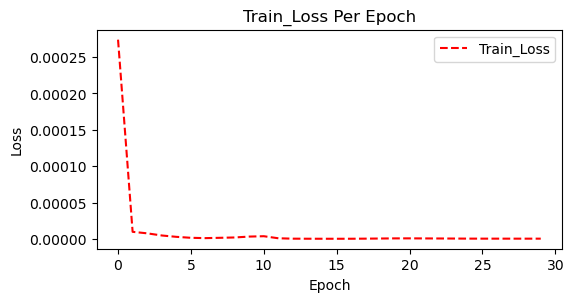

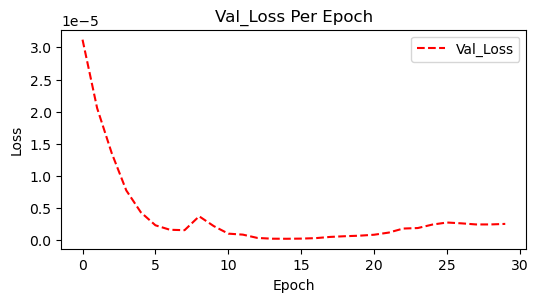

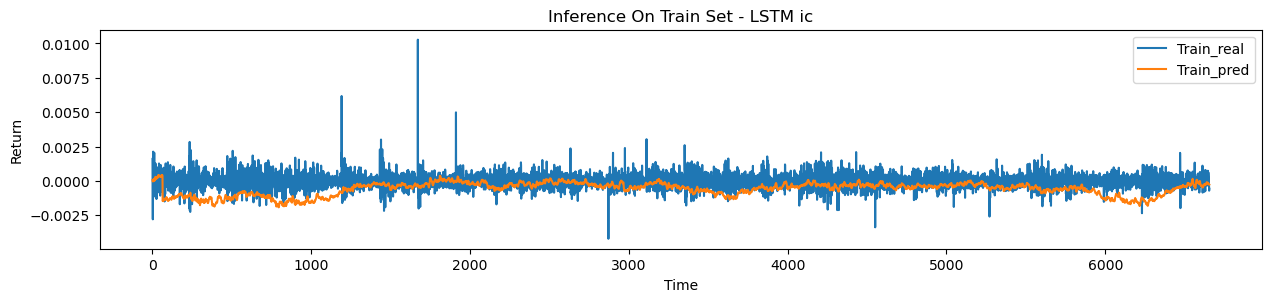

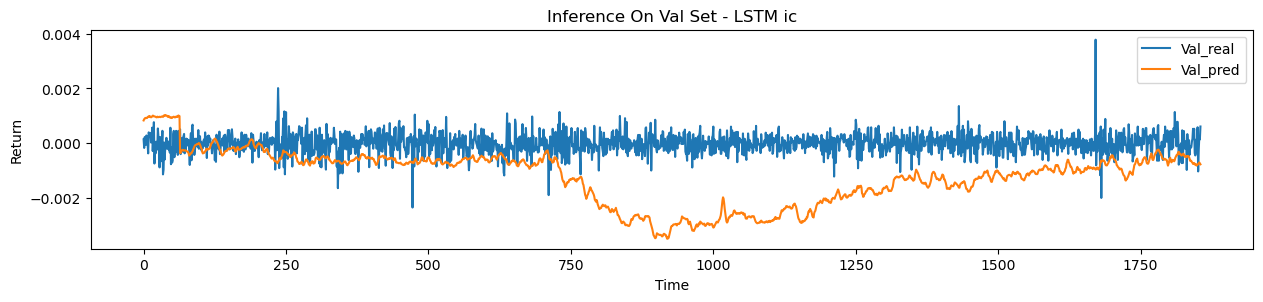

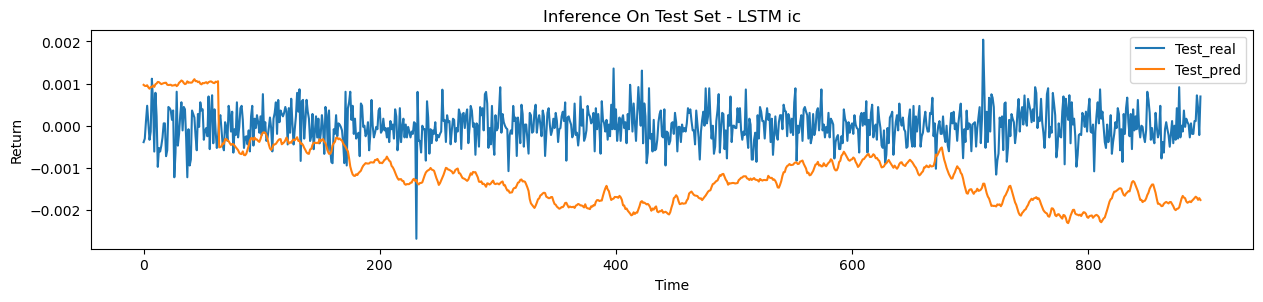

In [10]:
# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)